In [ ]:
%pip install torch torchvision matplotlib pandas timm

In [22]:
import torch
import torchvision
import timm
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

# Import the transformer model deit_small_patch16_224
# from torchvision.models import deit_small_patch16_224 as deit_model

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

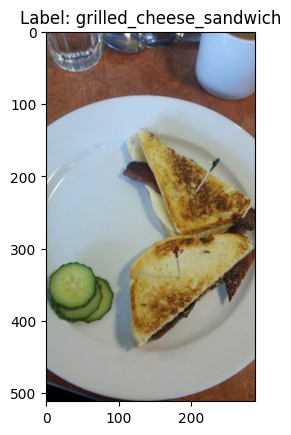

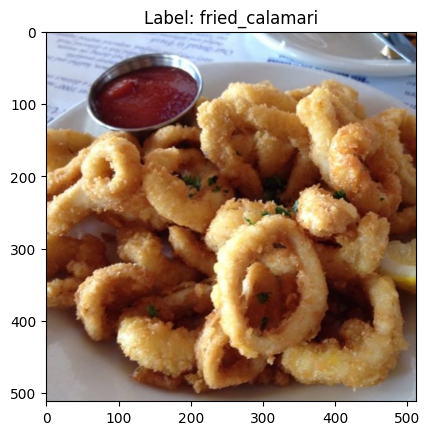

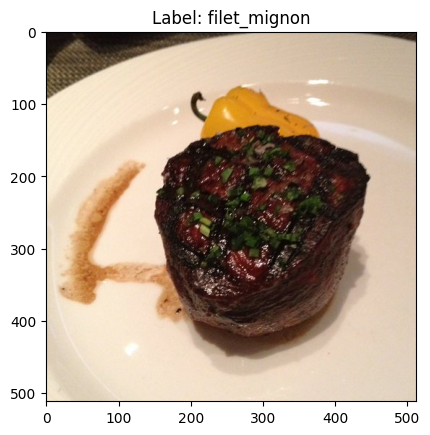

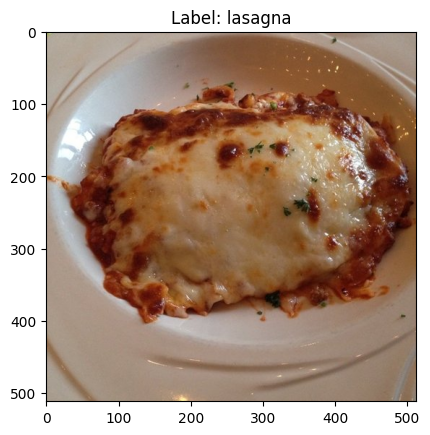

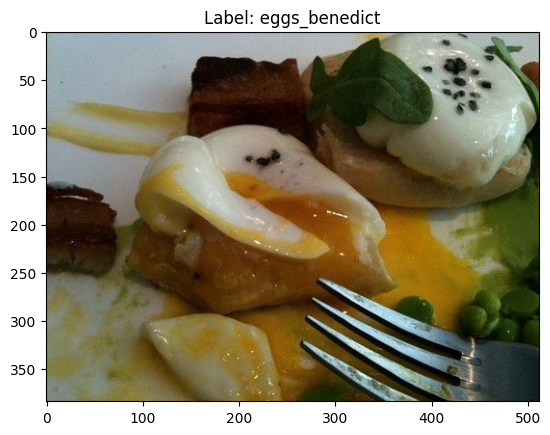

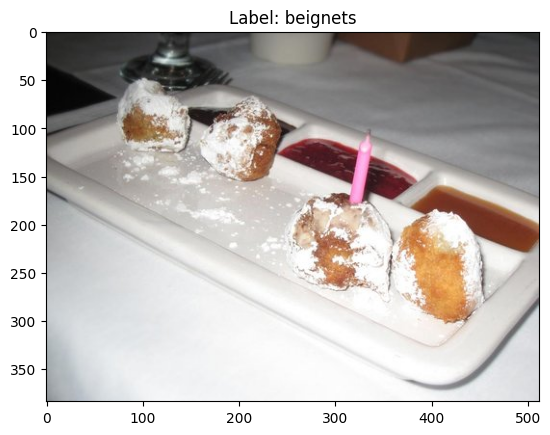

In [28]:
# Load the Oxford Pets dataset
dataset = datasets.Food101("../data", download=True)

classes = dataset.classes
print(classes)

img_count = len(dataset._image_files)
# Print 6 random images
for _ in range(6):
  index = np.random.choice(img_count, replace=False)
  plt.imshow(dataset[index][0])
  plt.title(f"Label: {classes[dataset[index][1]]}")
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


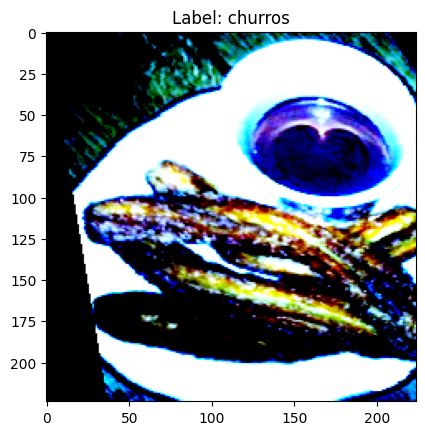

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


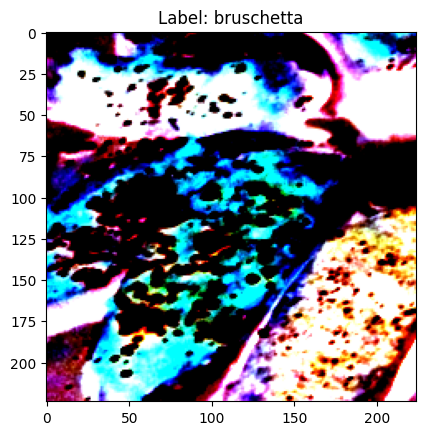

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.1659663].


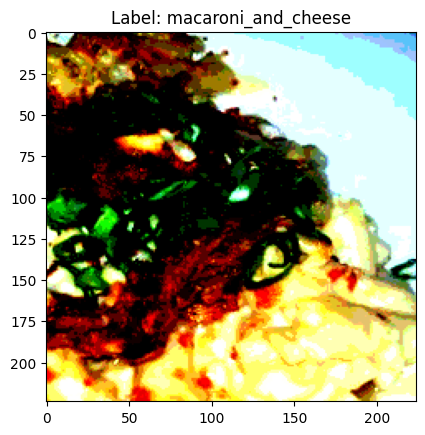

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


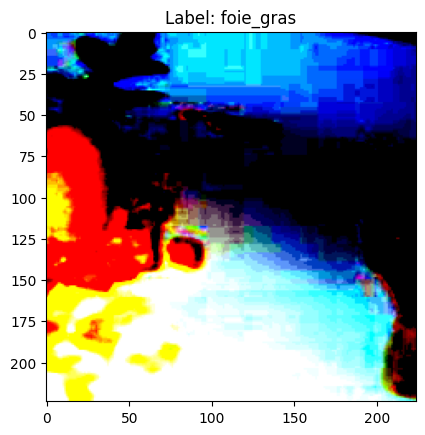

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


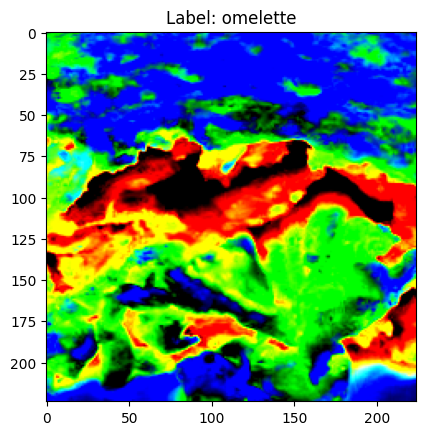

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


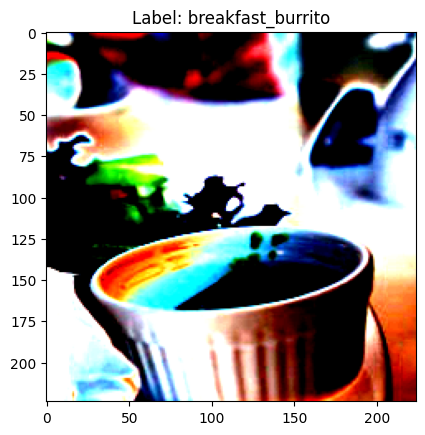

In [32]:
# Resize the images to 224x224
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.IMAGENET),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

dataset.transform = train_transform

for _ in range(6):
  index = np.random.choice(img_count, replace=False)
  plt.imshow(dataset[index][0].permute(1, 2, 0).numpy())
  plt.title(f"Label: {classes[dataset[index][1]]}")
  plt.show()

In [ ]:
# Load the pre-trained DeiT model

In [ ]:
#Prepare the model

In [ ]:
# Train 

In [ ]:
# Test the model

In [ ]:
# Throw our own images in to check!